# Practice - SAR Nonlinear Binomial Models

## Spatially Adjusted Regression - Non-Linear Models (continuous response variable)

Standard Logistic Regression vs Logistic Regression with Eigenvector Spatial Filter

What if the response variables are not binary, but rather take the form of percentages? In such cases, a binomial model may be an option...if you desire the predicted values to lie somewhere between 0.0 and infinity.

In this practice, it is assumed that we are working under a non-linear, non-normal probability model. 

The goals of this practice are to: 

a) evaluate a standard logistic regression using a continuous dependent variable when spatial autocorrelation may be present, and 

b) evaluate the same relationships given the ability to adjust for spatial autocorrelation using the rho term obtained from a logistic model adjusted with an eigenvector spatial filter.

### Load relevant libraries

Documentation for the R libraries used in this notebook can be found at: 
   
  
  - [rgdal library](https://web.dsa.missouri.edu/static/PDF/R/rgdal.pdf)   
  
  - [classInt library](https://web.dsa.missouri.edu/static/PDF/R/classInt.pdf)
  
  - [spdep library](https://web.dsa.missouri.edu/static/PDF/R/spdep.pdf)
  
  - [RColorBrewer library](https://web.dsa.missouri.edu/static/PDF/R/RColorBrewer.pdf)  
  
  - [car library](https://web.dsa.missouri.edu/static/PDF/R/car.pdf)
  
  - [MASS library](https://web.dsa.missouri.edu/static/PDF/R/MASS.pdf)

In [1]:
## Load relevant R packages.
inLibraries = list('rgdal','spdep','spatialreg','classInt','car','RColorBrewer','MASS')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}

## Resize plot area.
options(repr.plot.width=6, repr.plot.height=6)

## US Farming Data

In this practice, we will be working with county data on agricultural practices in the USA (usagriculture/usfarming.shp). Elements of this dataset were obtained from the 2012 [US Ag. Census](https://web.dsa.missouri.edu/static/PDF/R/Ag_Census_Map_documentation_07172015.pdf) ; External source: https://agcensus.library.cornell.edu/census_year/2012-census/. The fields in this dataset may seem kinda mystical, but they are documented in depth at the website noted above (download the associated [Ag. Census Excel](https://web.dsa.missouri.edu/static/PDF/R/Ag_Census_Map_data_07172015.xlsx).

There is also a field in the usfarming polygons named 'GRIDCODE', which reflects mean annual precipitation between 1990 and 2009 for each county. The original precipitation data was obtained from (USGS United States Average Annual Precipitation 1990-2009, data can be found at - External source: https://data.globalchange.gov/dataset/usgs-united-states-average-annual-precipitation-1990-2009). The precip. data were then spatially joined to the county polygons.

Note: By all means, this is not really a large dataset (3070 records), however, since all operations will be conducted on a remote server, the size of the data coupled with the complexity of the methods could result in longer times required to obtain the results for each step.

First, read in the county level data.

In [2]:
## Read in the featureclass.
#inFeatures <- readOGR("/dsa/data/geospatial/DS8612/usagriculture","usfarming",GDAL1_integer64_policy=TRUE)
inFeatures <- readOGR(dsn="C:/Users/ja2qm/MIZZOU/_MotherFolderAmanWorks/Aman thesis works/_1_FinalTopic/_CAADRIA2022/Paper_2/SensingTheCity_Stat_R_TimScript/Script from Tim/usfarmsdata", layer="usfarming")

OGR data source with driver: ESRI Shapefile 
Source: "C:\Users\ja2qm\MIZZOU\_MotherFolderAmanWorks\Aman thesis works\_1_FinalTopic\_CAADRIA2022\Paper_2\SensingTheCity_Stat_R_TimScript\Script from Tim\usfarmsdata", layer: "usfarming"
with 3070 features
It has 93 fields
Integer64 fields read as strings:  Join_Count TARGET_FID cntyn ID GRIDCODE 


## Subset Features

As agricultural conditions vary considerably over the U.S., let's select a specific state to analyze - California.

Note that state names are not explicitly included in the dataset. However, the FIPS (Federal Information Processing Specification) code for each county is provided. Typically, the first two digits of a FIPS code reflect the state id number while the last three reflect a specific county within a state.  In this dataset, the 'atlas_stco' field contains the FIPS code as a character variable. Thus, in order to select the first two characters associated with a particular state, we need some way to match one portion of a string to another. There are several ways to do this. In this case, first a new field is added to the dataframe 'stcode' and populated with the first two characters in the 'atlas_stco' field which is the FIPS code. Next, grep() is used to select the FIPS code prefixes which correspond with the FIPS code of California ('06').

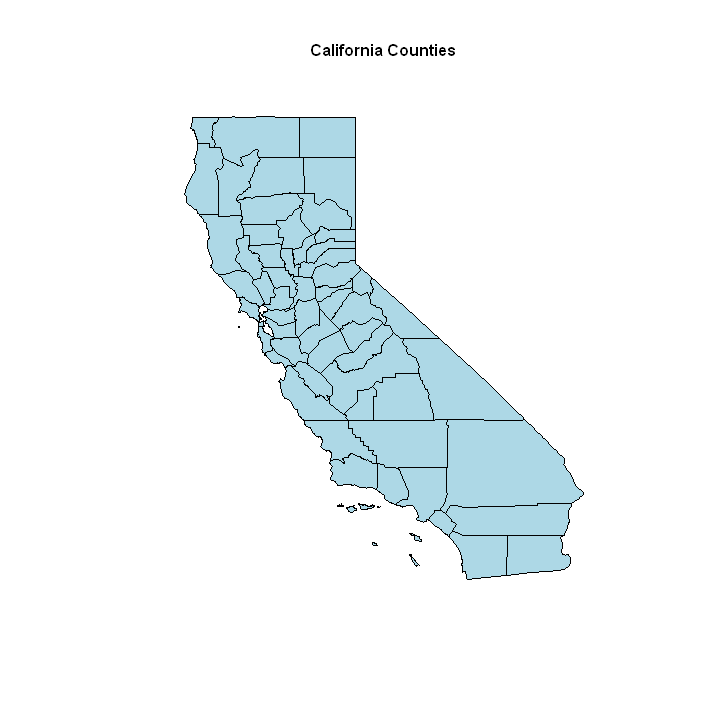

In [3]:
## Add new column to data frame and populate with first two numbers of FIPS code.
inFeatures@data$stcode <- substr(inFeatures@data$atlas_stco, start=1, stop=2)

## Select features with a state FIPS code beginning with...
inFeaturesSubsetA <- inFeatures[grep("06", inFeatures@data$stcode), ]

## Visualize the state selected.
plot(inFeaturesSubsetA,col="lightblue", lwd=.2, main="California Counties",cex.main=.8)

## Generate Neighborhoods for Features¶

As before, generate neighborhoods for each feature. Then test the neighborhoods to see if they are valid. Retain only the features with valid neighborhoods.

In [4]:
## Identify the neighbors of each feature.
inFeaturesSubsetA.nb <- poly2nb(inFeaturesSubsetA ,queen=TRUE)

## Select features with at least one neighbor.
inFeaturesSubset <- inFeaturesSubsetA[card(inFeaturesSubsetA.nb) >= 1, ]

## Identify the neighbors of each feature having at least one neighbor.
inFeaturesSubset.nb <- poly2nb(inFeaturesSubset, queen=TRUE)

## Retrieve neighborhood list.
inFeaturesSubset.listb <- nb2listw(inFeaturesSubset.nb,style="B")
inFeaturesSubset.listw <- nb2listw(inFeaturesSubset.nb,style="W")

## Analysis Variables

Configure the variables to analyze. 

In this practice, the dependent variable is 'y12_M082_1' (acres of irrigated land as percent of land in farms acreage (year 2012)) and the explanatory variable will be 'GRIDCODE' (mean annual rainfall 1990-2009). Also, 'y12_M249_1' is the number of farms in 2012, a variable that may be of use later on.

Non-linear logistic regression expects the response variable values to range between 0 and 1. As is, the 'y12_M082_1' rates range between 0 and 100%. Thus, before a logistic regression can be applied, they need to be rescaled to the [0,1] range (i.e. divided by 100 in this case).

In [5]:
## Acres of irrigated land as a percent of land in farms acreage.
inVa <- inFeaturesSubset$y12_M082_1

## Number of farms in 2012.
inVb <- inFeaturesSubset$y12_M249_1 

## Response variable.
YVar <- inVa/100

## Explanatory variable.
Exp1 <- inFeaturesSubset$GRIDCODE

### Visualize the Observed  Variable

Visualize the dependent variable.

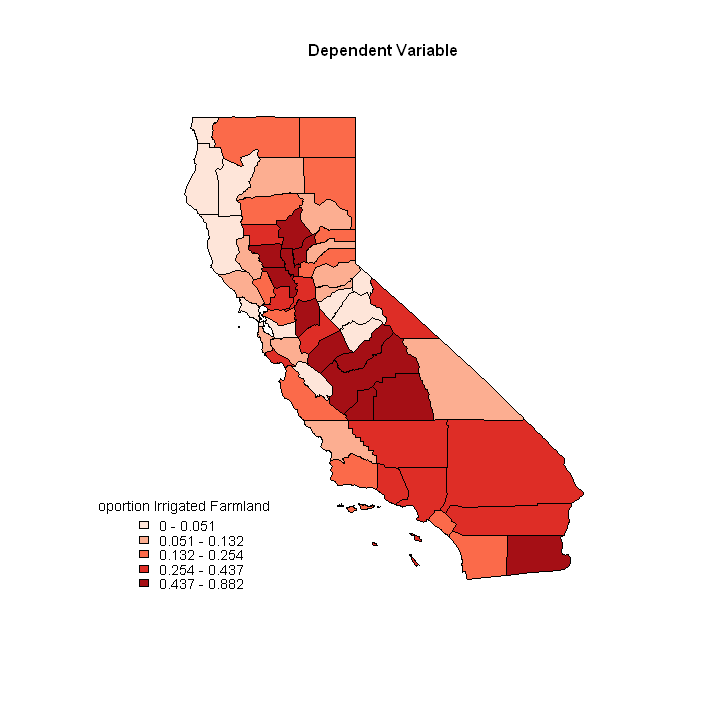

In [6]:
## Classify the variable.
numcat <- 5
cate <- classIntervals(YVar, numcat, style="quantile")

## Assign colors to categories.
pal <- brewer.pal(numcat,"Reds")
cols <- findColours(cate,pal)

## Visualize the dependent variable.
plot(inFeaturesSubset, col=cols, lwd=.2,main="Dependent Variable",cex.main=.8)
brks <- round(cate$brks,3)
leg <- paste(brks[-(numcat+1)], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="Proportion Irrigated Farmland",cex=.7)

### Visualize the Explanatory Variable

In [7]:
## Classify the variable.
numcat <- 5
cate <- classIntervals(Exp1, numcat, style="quantile")

## Assign colors to categories.
pal <- brewer.pal(numcat,"Reds")
cols <- findColours(cate,pal)

## Visualize the explanatory variable.
plot(inFeaturesSubset, col=cols, lwd=.2,main="Explanatory Variable",cex.main=.8)
brks <- round(cate$brks,3)
leg <- paste(brks[-(numcat+1)], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="Average Annual Rainfall",cex=.7)

ERROR: Error in classIntervals(Exp1, numcat, style = "quantile"): var is not numeric


## Examine Test Statistics for Autocorrelation

Is there any indication of significant spatial autocorrelation within this response variable?

In [8]:
## Run the Moran test.
moran.test(YVar, inFeaturesSubset.listb)

## Run the Geary test.
geary.test(YVar, inFeaturesSubset.listb)


	Moran I test under randomisation

data:  YVar  
weights: inFeaturesSubset.listb    

Moran I statistic standard deviate = 2.9575, p-value = 0.001551
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.221279446      -0.017543860       0.006520776 



	Geary C test under randomisation

data:  YVar 
weights: inFeaturesSubset.listb 

Geary C statistic standard deviate = 2.8001, p-value = 0.002555
alternative hypothesis: Expectation greater than statistic
sample estimates:
Geary C statistic       Expectation          Variance 
      0.724123989       1.000000000       0.009707066 


## Logistic Regression

First, let's estimate a standard logistic regression model. In this case, it will be specified as 'quasibinomial' given the response variable is actually continuous.

In [9]:
## Conduct logistic regression.
YVar.base <- glm(YVar ~ Exp1, family=quasibinomial)

## Examine model results.
summary(YVar.base)
disp <- summary(YVar.base)$dispersion


Call:
glm(formula = YVar ~ Exp1, family = quasibinomial)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6580  -0.1694   0.0000   0.1138   0.7028  

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept) -1.957e+01  4.157e+03  -0.005    0.996
Exp112       2.158e+01  4.157e+03   0.005    0.996
Exp116       1.999e+01  4.157e+03   0.005    0.996
Exp117       1.860e+01  4.157e+03   0.004    0.996
Exp118       1.874e+01  4.157e+03   0.005    0.996
Exp120       1.855e+01  4.157e+03   0.004    0.996
Exp121       1.862e+01  4.157e+03   0.004    0.996
Exp122       2.019e+01  4.157e+03   0.005    0.996
Exp123       1.683e+01  4.157e+03   0.004    0.997
Exp124       1.881e+01  4.157e+03   0.005    0.996
Exp125       1.772e+01  4.157e+03   0.004    0.997
Exp126       1.773e+01  4.157e+03   0.004    0.997
Exp127       1.899e+01  4.157e+03   0.005    0.996
Exp128      -5.612e-08  5.879e+03   0.000    1.000
Exp129       1.956e+01  4.157e+03   0.005    0.9

### Examine Autocorrelation in Residuals

Is spatial autocorrelation affecting the residuals obtained via the basic logistic model specification?  Well, that seems to be the case...something that really doesn't bode well for interpretation of the results!

In [10]:
## Get logistic residuals.
YVar.base.res <- residuals(YVar.base, type="response")

## Analyze autocorrelation test statistics for residuals using the Moran test.
moran.test(YVar.base.res, inFeaturesSubset.listb)
## Analyze autocorrelation test statistics for residuals using the Geary test.
geary.test(YVar.base.res, inFeaturesSubset.listb)


	Moran I test under randomisation

data:  YVar.base.res  
weights: inFeaturesSubset.listb    

Moran I statistic standard deviate = -1.6763, p-value = 0.9532
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     -0.151527382      -0.017543860       0.006388682 



	Geary C test under randomisation

data:  YVar.base.res 
weights: inFeaturesSubset.listb 

Geary C statistic standard deviate = -1.9347, p-value = 0.9735
alternative hypothesis: Expectation greater than statistic
sample estimates:
Geary C statistic       Expectation          Variance 
       1.20714624        1.00000000        0.01146403 


## Develop an Eigenvector Spatial Filter

Now, let's try to improve upon this base logistic specification and build an Eigenvector spatial filter.

### Generate Eigenvalues and Eigenvectors

The first step is to compute the 'MBM' matrix. Note that matrix 'B' is the spatial weights matrix.

The second step is to generate eigenvalues and eigenvectors that correspond with the dimensions of the input data.

The third step is to do a first cut to weed out eigenvectors that are likely not that relevant for explaining spatial autocorrelation.

In [11]:
## Compute MBM.
n <- length(inFeaturesSubset)
M <- diag(n) - matrix(1,n,n)/n
B <- listw2mat(inFeaturesSubset.listb)

MBM <- M %*% B %*% M

## Compute eigenvectors and values.
eig <- eigen(MBM, symmetric=T)

## Select most relevant eigenvectors (first cut).
cutThreshold <- 0.25
EV <- as.data.frame( eig$vectors[ ,eig$values/eig$values[1] > cutThreshold])
colnames(EV) <- paste("EV", 1:NCOL(EV),sep="")

### Use Stepwise Regression to Refine Set of Eigenvectors

Refine the set of relevant eigenvectors using step-wise regression.  How many Eigenvectors are selected?  According to the code, which parameters influence how many Eigenvectors are selected?  Hey, what is an Eigenvector anyway?

In [12]:
## Conduct stepwise regression to spatially filter Eigenvectors.
## Specify full model with all eigenvectors.
YVar.full <- glm(YVar ~ Exp1 + ., data=EV,family=binomial)

## Apply stepwise regression.
YVar.sf <- stepAIC(glm(YVar~Exp1, data=EV, family=binomial),scale=disp, scope=list(upper=YVar.full), direction="forward",k=1.6)
YVar.sf
coefnm <- names(coef(YVar.sf))

## Extract upto exComp components to analyze from final model.
exComp <- 7
ctit <- 1
formula2 <- c(YVar ~ Exp1)
formlist <- list()
formula3 <- c()
incnt <- 1
for (ele in coefnm)   {
    if ((ctit <= exComp)&& (startsWith(ele,"EV"))) {
        formula2 <- paste(formula2, "+", sep=" ")
        formula2 <- paste(formula2, ele, sep=" ")
        s1 = unlist(strsplit(ele, split='EV', fixed=TRUE))[2]
        formlist[[ctit]] <- as.numeric(s1)
        
        ctit <- ctit + 1
    }
    incnt <- incnt + 1   
}

formula3 <- unlist(formlist)

Warning message in eval(family$initialize):
"non-integer #successes in a binomial glm!"
Warning message in eval(family$initialize):
"non-integer #successes in a binomial glm!"


Start:  AIC=89.51
YVar ~ Exp1



Warning message in eval(family$initialize):
"non-integer #successes in a binomial glm!"
Warning message in eval(family$initialize):
"non-integer #successes in a binomial glm!"
Warning message in eval(family$initialize):
"non-integer #successes in a binomial glm!"
Warning message in eval(family$initialize):
"non-integer #successes in a binomial glm!"
Warning message in eval(family$initialize):
"non-integer #successes in a binomial glm!"
Warning message in eval(family$initialize):
"non-integer #successes in a binomial glm!"
Warning message in eval(family$initialize):
"non-integer #successes in a binomial glm!"
Warning message in eval(family$initialize):
"non-integer #successes in a binomial glm!"
Warning message in eval(family$initialize):
"non-integer #successes in a binomial glm!"
Warning message in eval(family$initialize):
"non-integer #successes in a binomial glm!"
Warning message in eval(family$initialize):
"non-integer #successes in a binomial glm!"
Warning message in eval(family$i

       Df Deviance    AIC
+ EV10  1   3.4486 88.684
+ EV8   1   3.5191 89.156
+ EV5   1   3.5719 89.510
<none>      3.8112 89.511
+ EV4   1   3.6303 89.900
+ EV2   1   3.6891 90.294
+ EV13  1   3.7007 90.372
+ EV11  1   3.7644 90.798
+ EV12  1   3.7716 90.846
+ EV3   1   3.7806 90.906
+ EV6   1   3.7887 90.961
+ EV14  1   3.7919 90.982
+ EV7   1   3.8020 91.049
+ EV9   1   3.8059 91.076
+ EV1   1   3.8074 91.086


Warning message in eval(family$initialize):
"non-integer #successes in a binomial glm!"



Step:  AIC=91.47
YVar ~ Exp1 + EV10




Call:  glm(formula = YVar ~ Exp1 + EV10, family = binomial, data = EV)

Coefficients:
(Intercept)       Exp112       Exp116       Exp117       Exp118       Exp120  
   -20.3064      22.6499      21.0404      19.0343      19.6479      19.1159  
     Exp121       Exp122       Exp123       Exp124       Exp125       Exp126  
    19.3263      20.1791      17.7108      19.2608      19.0856      18.1835  
     Exp127       Exp128       Exp129       Exp130       Exp133       Exp134  
    19.8287       0.8084      20.0467      19.6140      20.1948      16.7446  
     Exp136       Exp137       Exp138       Exp140       Exp141       Exp144  
    16.3437      17.6471      19.9049      18.7808      18.3448      19.9961  
     Exp146       Exp148       Exp150       Exp151       Exp152       Exp156  
    18.3806      18.4086      18.8431      19.7543      18.2902      19.7986  
     Exp160       Exp164       Exp165       Exp174         EV10  
    18.3990      16.9915      15.2206      15.9309      -

### Given the selected Eigenvectors, run the spatially filtered model

How should the results be interpreted?  How do the results differ from the basic logistic regression?  Note that deviance of spatially filtered regression is much lower than that of the basic logistic regression.  What is deviance and dispersion and how should those be interpreted?

In [13]:
## Populate model with selected Eigenvectors.
YVar.sf <- glm(formula2, data=EV, family=quasibinomial)
summary(YVar.sf)

paste("Deviance Base Model = ",summary(YVar.base)$deviance/YVar.base$df.residual)
paste("Deviance Spatial Filter = ",summary(YVar.sf)$deviance/YVar.sf$df.residual)
paste("Dispersion = ",summary(YVar.sf)$dispersion)


Call:
glm(formula = formula2, family = quasibinomial, data = EV)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.61783  -0.13310   0.00000   0.07947   0.80476  

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)  -20.3064  4111.7662  -0.005    0.996
Exp112        22.6499  4111.7664   0.006    0.996
Exp116        21.0404  4111.7663   0.005    0.996
Exp117        19.0343  4111.7663   0.005    0.996
Exp118        19.6479  4111.7663   0.005    0.996
Exp120        19.1159  4111.7663   0.005    0.996
Exp121        19.3263  4111.7663   0.005    0.996
Exp122        20.1791  4111.7663   0.005    0.996
Exp123        17.7108  4111.7666   0.004    0.997
Exp124        19.2608  4111.7663   0.005    0.996
Exp125        19.0856  4111.7665   0.005    0.996
Exp126        18.1835  4111.7664   0.004    0.997
Exp127        19.8287  4111.7663   0.005    0.996
Exp128         0.8084  5814.9156   0.000    1.000
Exp129        20.0467  4111.7663   0.005    0

[1] "Deviance Base Model =  0.158799240300324"

[1] "Deviance Spatial Filter =  0.149937744312537"

[1] "Dispersion =  0.146189341408046"

### Examine Test Statistics for Autocorrelation in Spatial Filter Model

Is spatial autocorrelation at work within the spatial filter?

In [14]:
## Analyze autocorrelation test statistics for residuals.
sfilter <- as.matrix(EV[ ,formula3]) %*% as.matrix(YVar.sf$coefficients[c(-1,-2)])
sfvector <- as.vector(sfilter)

## Apply Moran test to the filter.
moran.test(sfvector, inFeaturesSubset.listb)
## Apply Geary test to the filter.
geary.test(sfvector, inFeaturesSubset.listb)

ERROR: Error in as.matrix(EV[, formula3]) %*% as.matrix(YVar.sf$coefficients[c(-1, : non-conformable arguments


## Examine Autocorrelation in Spatially Filtered Residuals

Is spatial autocorrelation affecting the residuals obtained given the spatial filter was applied?

In [ ]:
## Select out the model residuals.
YVar.sf.res <- residuals(YVar.sf, type="response")

## Apply the Moran test to the residuals.
moran.test(YVar.sf.res, inFeaturesSubset.listb)
## Apply the Geary test to the residuals.
geary.test(YVar.sf.res, inFeaturesSubset.listb)

### Visualize the Fitted Values

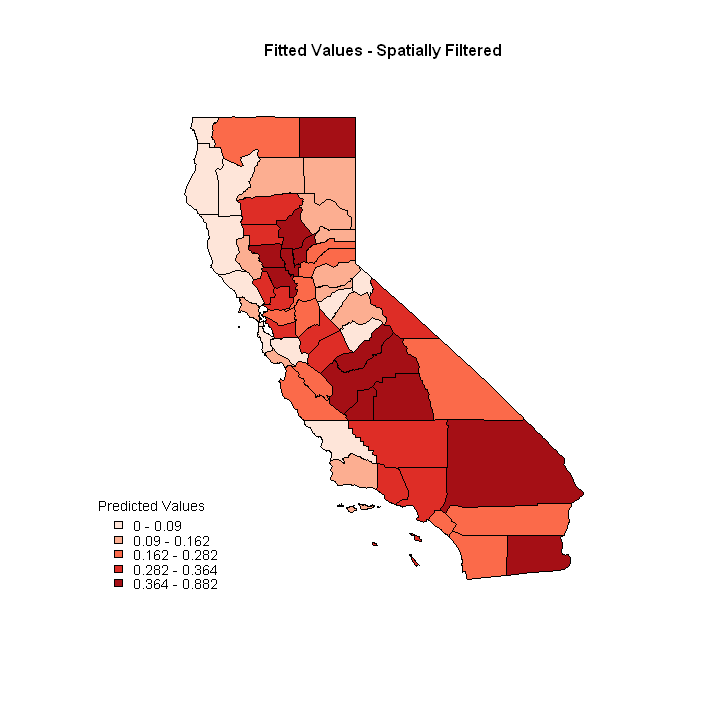

In [15]:
## Classify the variable.
numcat <- 5
cate <- classIntervals(YVar.sf$fitted, numcat, style="quantile")

## Assign colors to categories.
pal <- brewer.pal(numcat,"Reds")
cols <- findColours(cate,pal)

## Visualize the fitted values.
plot(inFeaturesSubset, col=cols, lwd=.2,main="Fitted Values - Spatially Filtered",cex.main=.8)
brks <- round(cate$brks,3)
leg <- paste(brks[-(numcat+1)], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="Predicted Values",cex=.7)

### Visualize the Spatial Filter

Display the spatial filter to get a sense of how spatial autocorrelation was ultimately modeled in this application.

In [16]:
## Classify the variable.
numcat <- 5
cate <- classIntervals(sfvector, numcat, style="quantile")

## Assign colors to categories.
pal <- brewer.pal(numcat,"Reds")
cols <- findColours(cate,pal)

## Visualize the spatial filter.
plot(inFeaturesSubset, col=cols, lwd=.2,main="Spatial Filter",cex.main=.8)
brks <- round(cate$brks,3)
leg <- paste(brks[-(numcat+1)], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="Filter Values",cex=.7)

ERROR: Error in is.factor(var): object 'sfvector' not found


# SAVE YOUR NOTEBOOK, then `File > Close and Halt`

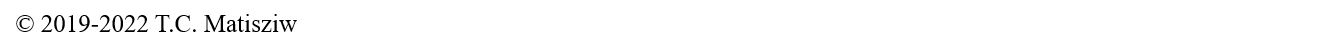